<a href="https://colab.research.google.com/github/kiakass/python/blob/master/%EC%9D%98%EC%82%AC%EA%B2%B0%EC%A0%95%EB%82%98%EB%AC%B4_%EB%B8%94%EB%A1%9C%EA%B7%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch04.의사결정나무

## 1.기본 package 설정

In [ ]:
## 기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기

## 데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환

# 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split 

# 모델구축 
from sklearn.tree import DecisionTreeClassifier # 의사 결정 트리
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 : 앙상블

## 모델검정
from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # 정확도, 민감도 등
from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

## 7.최적화
from sklearn.model_selection import cross_validate # 교차타당도
from sklearn.pipeline import make_pipeline # 파이프라인 구축
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝
from sklearn.model_selection import cross_val_score # 교차타당도 # 추가

## 2.데이터 가져오기

### 2.1 데이터프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

- 자료구조 살펴보기

### 3.1 data(X) 레이블 인코딩
- 문자형 자료를 숫자(범주형)로 인코딩 -> 범주형 변수를 가변수로 처리 : One Hot Encording
- 숫자형 자료를 표준화
- 단, 결정나무, 랜덤 포레스트, 나이브 베이즈 분류 : 원본데이터 그대로 유지

- 가변수 처리시 문자로 처리를 해야 변수명 구분이 쉬움

In [ ]:
# 1. 데이터 로딩
bank_df = pd.read_csv('https://raw.githubusercontent.com/kiakass/share/master/bank.csv')

## data , target 으로 분리
X = bank_df.drop(['Y'], axis=1)
y = bank_df['Y']

# 2. data 전처리
# 범주형 변수인 Education 을 문자로 바꾼후 onehot encoding 하는 방법입니다.
X['Education'] = X['Education'].replace ([1,2,3], ['Under','Grad','Prof'])
X = pd.get_dummies(X[['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Securities.Account', 'CD.Account', 'Online', 'CreditCard']],
                   columns=['Education'],
                   drop_first = True)
X.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities.Account,CD.Account,Online,CreditCard,Education_Prof,Education_Under
0,25,1,49,4,1.6,0,1,0,0,0,0,1
1,45,19,34,3,1.5,0,1,0,0,0,0,1
2,39,15,11,1,1.0,0,0,0,0,0,0,1
3,35,9,100,1,2.7,0,0,0,0,0,0,0
4,35,8,45,4,1.0,0,0,0,0,1,0,0


### 3.2 Class(target) 레이블 인코딩
- class(y)가 숫자형으로 되어 있기 때문에 변환 없음

In [ ]:
y

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: Y, Length: 5000, dtype: int64

## 4.훈련/검증용 데이터 분할
- test_size: 검증데이터 30%
- random_state : random seed 번호 = 1
- stratify : y(클래스)의 비율에 따라 분할

In [ ]:
# 3. 훈련/검증용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                   random_state=1, stratify=y)


## 5.모델구축

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=None,  #하이퍼파라메터
                              random_state=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

## 6. 모델검정

### 6.1 검증용 데이터로 예측
- predict (class로 표시)
- predict_proba (확률값으로 표시)

In [ ]:
clf_labels = ['Decision tree']
all_clf = [tree]

# 5. AUC_검정 : 정확도
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.940 (+/- 0.036) [Decision tree]


In [ ]:
y_pred = tree.predict(X_test)

### 6.2 정오분류표로 검정

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],1347,9
True[1],19,125


In [ ]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1356
           1       0.93      0.87      0.90       144

    accuracy                           0.98      1500
   macro avg       0.96      0.93      0.94      1500
weighted avg       0.98      0.98      0.98      1500



### 6.3 정확도, 민감도 확인
- 클래스가 2개일 경우에만 실행

In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 28
정확도: 0.981
정밀도: 0.933
재현율: 0.868
F1: 0.899


### 6.4 ROC 곡선 그리기
- decision_function 사용가능한 모델일 경우: tree.decision_function(X_test)
- decision_function 사용이 안되는 모델일 경우:tree.predict_proba(X_test)[:, 1]

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_test, tree.decision_function(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:, 1])

In [ ]:
fpr, tpr, thresholds

(array([0.        , 0.00663717, 1.        ]),
 array([0.        , 0.86805556, 1.        ]),
 array([2., 1., 0.]))

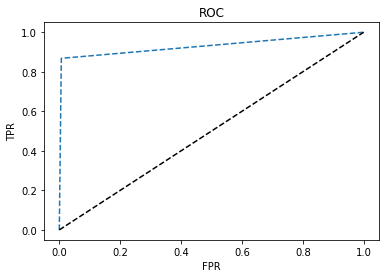

In [ ]:
plt.plot(fpr, tpr, '--', label="Decision Tree")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fpr], [tpr], 'r-', ms=10)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

## 부록. DT 그림 표시
- pip install pydotplus로 먼저 설치해야 함
- graphviz-2.38.msi 다운받은 후에 설치  
https://graphviz.gitlab.io/_pages/Download/Download_windows.html

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image #CART Tree 그림 만들어지고 이미지로 저장하고 화면으로 불러서 찍어줌
import pydotplus
import os #

- export_graphviz 설치 폴더를 인식시켜주어야 함
- (중요)아래와 같이 \ 로 표시되면 에러가 발생함
- os.environ['PATH'] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin\'
- \ --> /

In [ ]:
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [ ]:
feature_names = X.columns.tolist() # 변수들의 이름 : X의 columns
target_name = np.array(['No', 'Yes'])

In [ ]:
dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=target_name,
                           feature_names=feature_names,
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

True

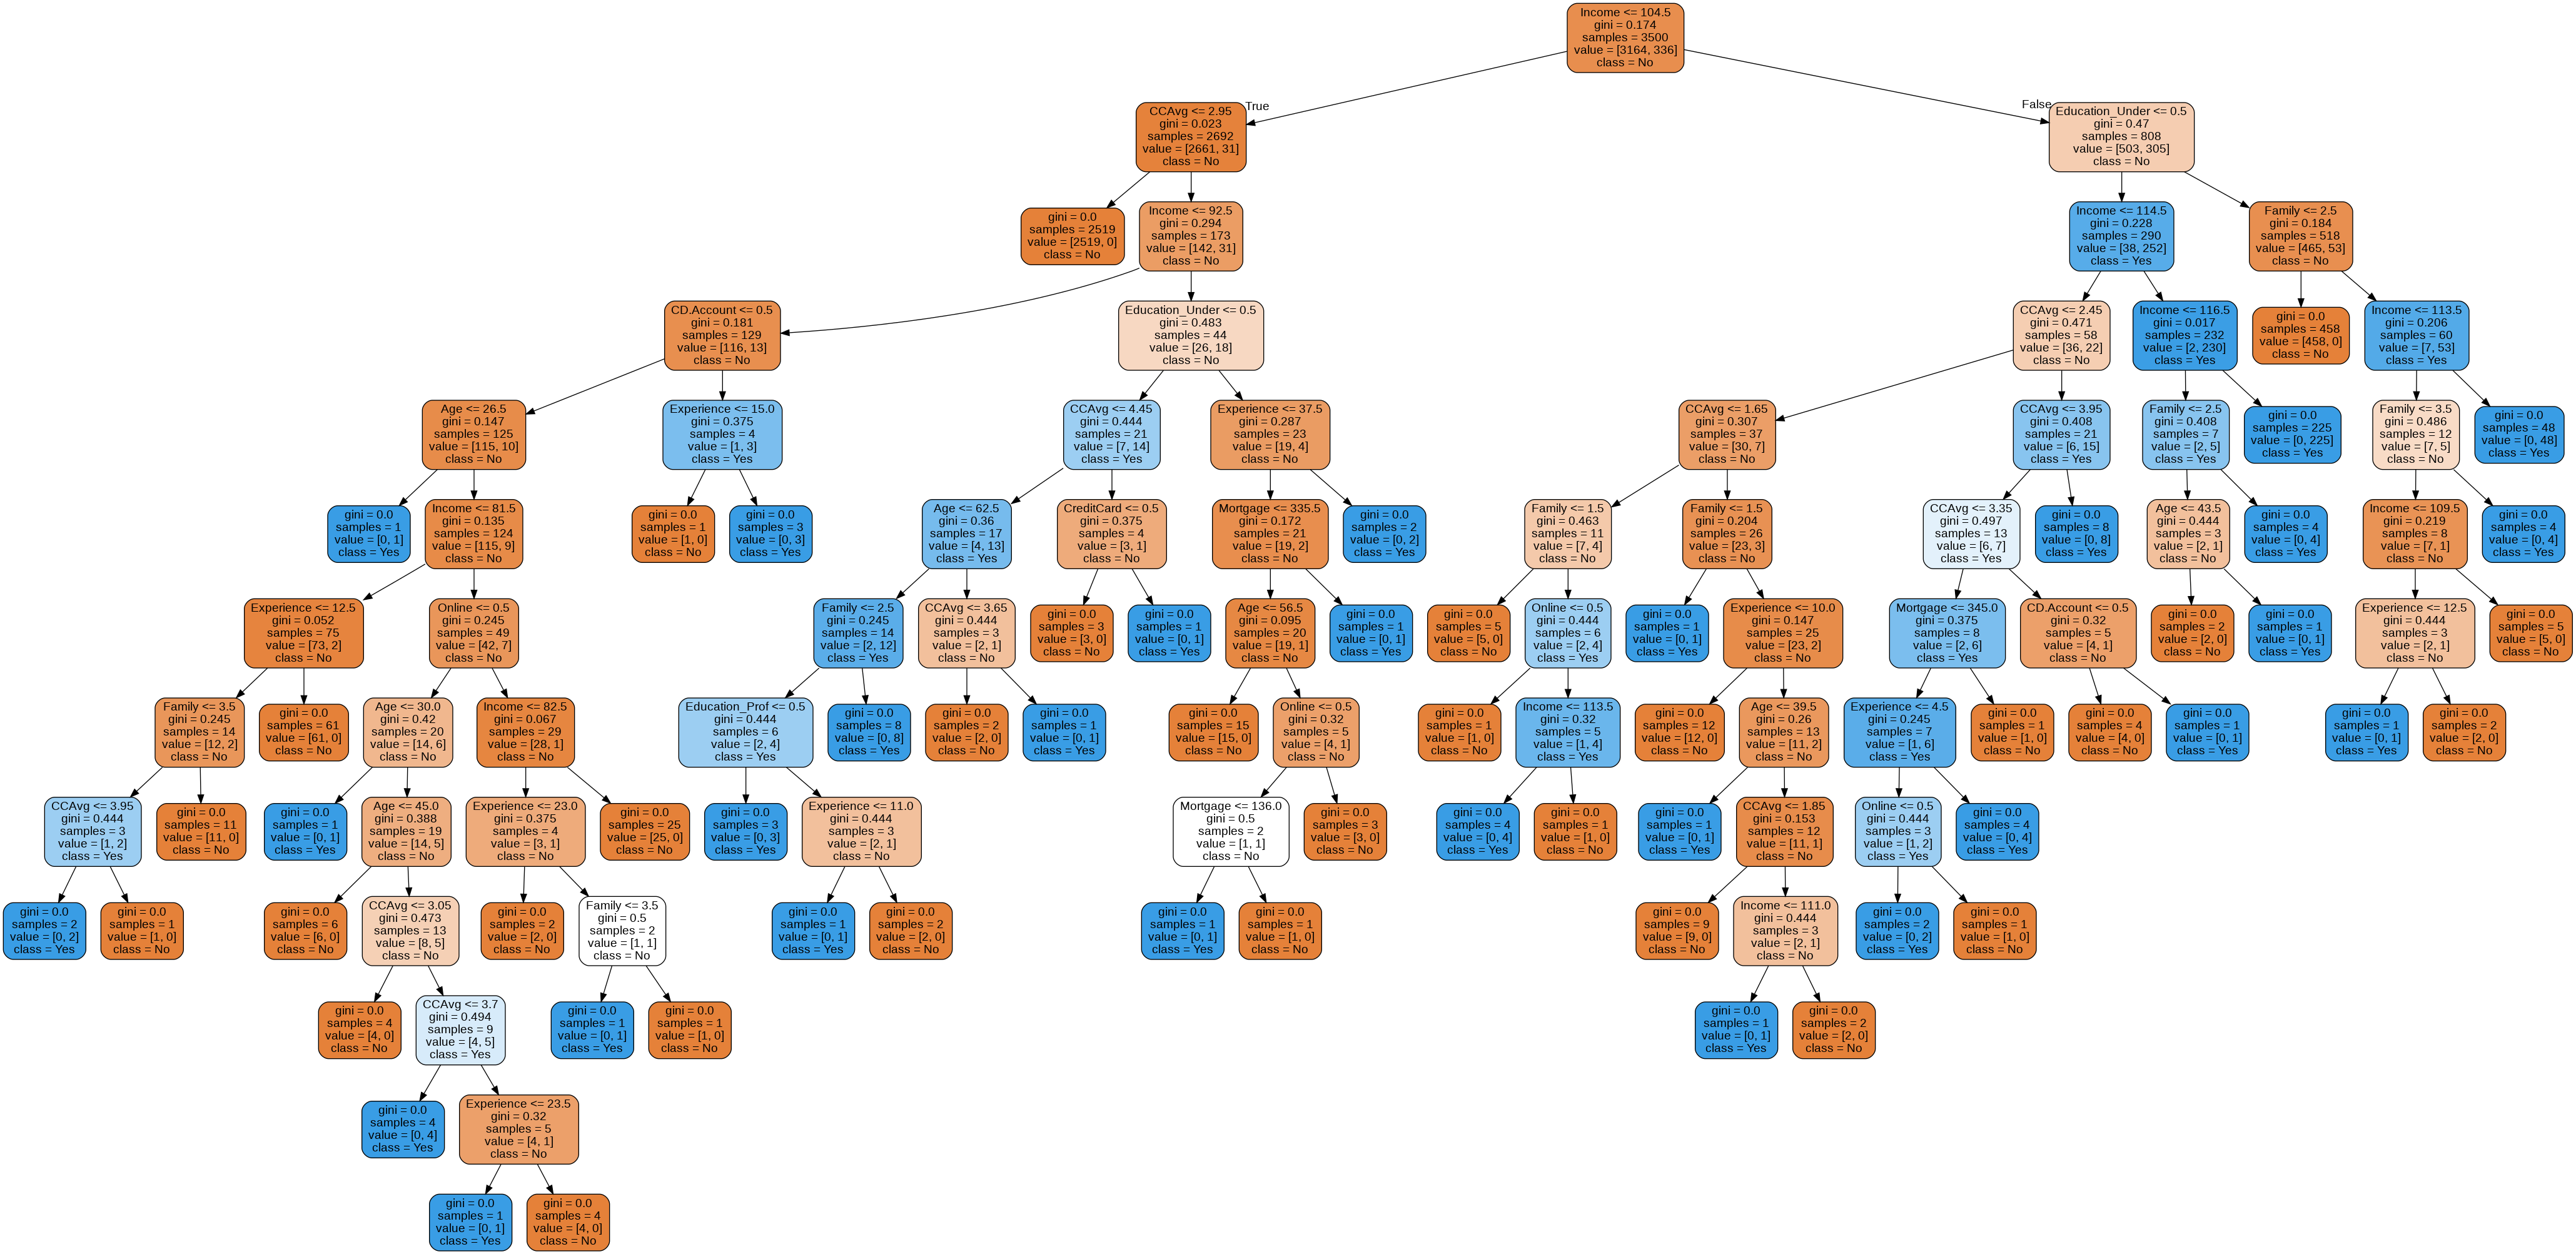

In [ ]:
dt_graph = pydotplus.graph_from_dot_data(dot_data)
Image(dt_graph.create_png())

## 7.최적화
- 교재 6장 (pp.218~250)

### 7.1 교차검정
- 5장, 6장의 default model 정확도= 0.981 과 비교
- 7.3부터 최적화를 위해서 교차검정 방법을 사용

In [ ]:
scores = cross_validate(estimator=tree, 
                        X=X_train, 
                        y=y_train, 
                        scoring=['accuracy'], # 정확도를 accuracy 를 써라-> class가다수일때  cf.f1, recall
                        cv=10, 
                        n_jobs=-1,
                        return_train_score=False)

print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), 
                                 np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.99428571 0.98285714 0.98       0.98285714 0.95428571 0.97714286
 0.99142857 0.98571429 0.96571429 0.98571429]
CV 정확도: 0.980 +/- 0.011


### 7.2 파이프라인 모델 만들기
- 파이프라인 : 모형을 만들때 하이퍼파라미터를 조정하기 위해 만드는 것 : 서로연결
- 파이프라인을 이용하여 최적 모델 만들기
- 기본모형은 아무 옵션이 없는 모델로 부터 시작
- 파라미터 옵션 확인: pipe_tree.get_params().keys()

In [ ]:
d_tree=DecisionTreeClassifier()
d_tree.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [ ]:
pipe_tree = make_pipeline(DecisionTreeClassifier()) # 모델을 여러개 쓸수 있음, 모델을 서로 연결하는 역할

In [ ]:
pipe_tree.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'decisiontreeclassifier', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_impurity_split', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__presort', 'decisiontreeclassifier__random_state', 'decisiontreeclassifier__splitter'])

### 7.3 학습 곡선으로 편향과 분산 문제 분석하기
- 데이터 개수에 의해서 정확도가 올라가는지 낮은지 체크 
- 훈렴 샘플링 수를 이용하여 편향과 분산 검정
- 편향: 정확도가 높은지 검정
- 분산: 훈련/검정 데이터의 정확도의 차이가 적은지

In [ ]:
np.linspace(0.1, 1.0, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

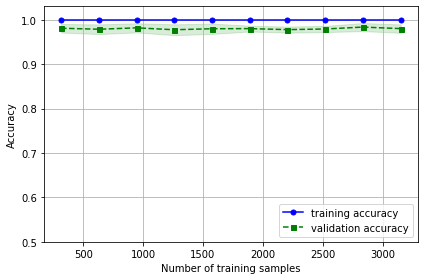

In [ ]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_tree, # 수정
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.03])  # 수정
plt.tight_layout()
plt.show()

### 7.4 검증 곡선으로 과대적합과 과소적합 조사하기
- 과대적합 : 파라미터가 많음 -> 파라미터 축소
- 과소적합 : 파라미터가 적음 -> 파라미터 추가

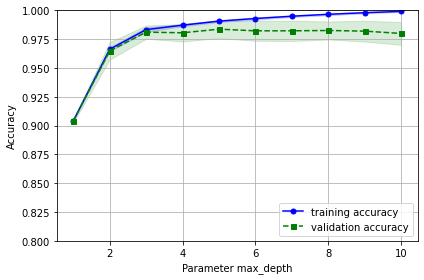

In [ ]:
param_range = [1,2,3,4,5,6,7,8,9,10]  # 수정
train_scores, test_scores = validation_curve(
                estimator=pipe_tree, # 수정
                X=X_train, 
                y=y_train, 
                param_name='decisiontreeclassifier__max_depth', ## 수정
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of max_depth') # 수정
plt.legend(loc='lower right')
plt.xlabel('Parameter max_depth') # 수정
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.00])  # 수정
plt.tight_layout()
plt.show()

### 7.5 하이퍼파라미터 튜닝
- 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝 -> 복수개의 parameter를 튜닝할수 있음
- 기계학습 모델의 성능을 결정하는 하이퍼 파라미터 튜닝

In [ ]:
tree_max_depth = [1,2,3,4,5,6,7,8,9,10] # 수정 , max_depth
tree_min_leaf = [10,20,30,40,50] # 수정 , min_leaf

param_grid = [{'decisiontreeclassifier__max_depth': tree_max_depth, # 수정, Dictionary
               'decisiontreeclassifier__min_samples_leaf': tree_min_leaf}] # 수정

gs = GridSearchCV(estimator=pipe_tree, # 수정, 파라미터들의 조합하여 돌려줌 10x5 = 50번
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print('Accuracy : ',gs.best_score_)
print('Best params. : ',gs.best_params_)

Accuracy :  0.9851428571428571
Best params. :  {'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_leaf': 10}


## 8.최적화 모델 검정
- 최적모델을 이용해 검정 데이터(full data) 최종 확인
- best_tree 로 모델명 변경

In [ ]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [ ]:
best_tree = gs.best_estimator_
best_tree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

- 검증용 데이터로 예측

In [ ]:
y_pred = best_tree.predict(X_test) 

- 정오분류표로 검정
![image.png](attachment:image.png)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],1346,10
True[1],19,125


In [ ]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1356
           1       0.93      0.87      0.90       144

    accuracy                           0.98      1500
   macro avg       0.96      0.93      0.94      1500
weighted avg       0.98      0.98      0.98      1500



- 정확도, 민감도 확인

In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 29
정확도: 0.981
정밀도: 0.926
재현율: 0.868
F1: 0.896


- ROC 곡선 그리기

In [ ]:
from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(y_test, best_tree.decision_function(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_tree.predict_proba(X_test)[:, 1])

In [ ]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.00368732, 0.00368732, 0.00368732,
        0.00737463, 0.01032448, 0.01106195, 0.0199115 , 0.02433628,
        0.02654867, 0.03613569, 0.04424779, 1.        ]),
 array([0.        , 0.75      , 0.79861111, 0.84722222, 0.85416667,
        0.86805556, 0.875     , 0.875     , 0.88888889, 0.91666667,
        0.9375    , 0.9375    , 0.95833333, 1.        ]),
 array([2.        , 1.        , 0.81818182, 0.8       , 0.6       ,
        0.54545455, 0.41666667, 0.4       , 0.36363636, 0.29032258,
        0.1875    , 0.11538462, 0.04761905, 0.        ]))

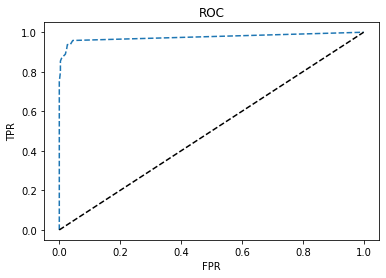

In [ ]:
plt.plot(fpr, tpr, '--', label="Decision Tree")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fpr], [tpr], 'r-', ms=10)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=6,
                              min_samples_leaf=10,     
                              random_state=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [ ]:
dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=target_name,
                           feature_names=feature_names,
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

True

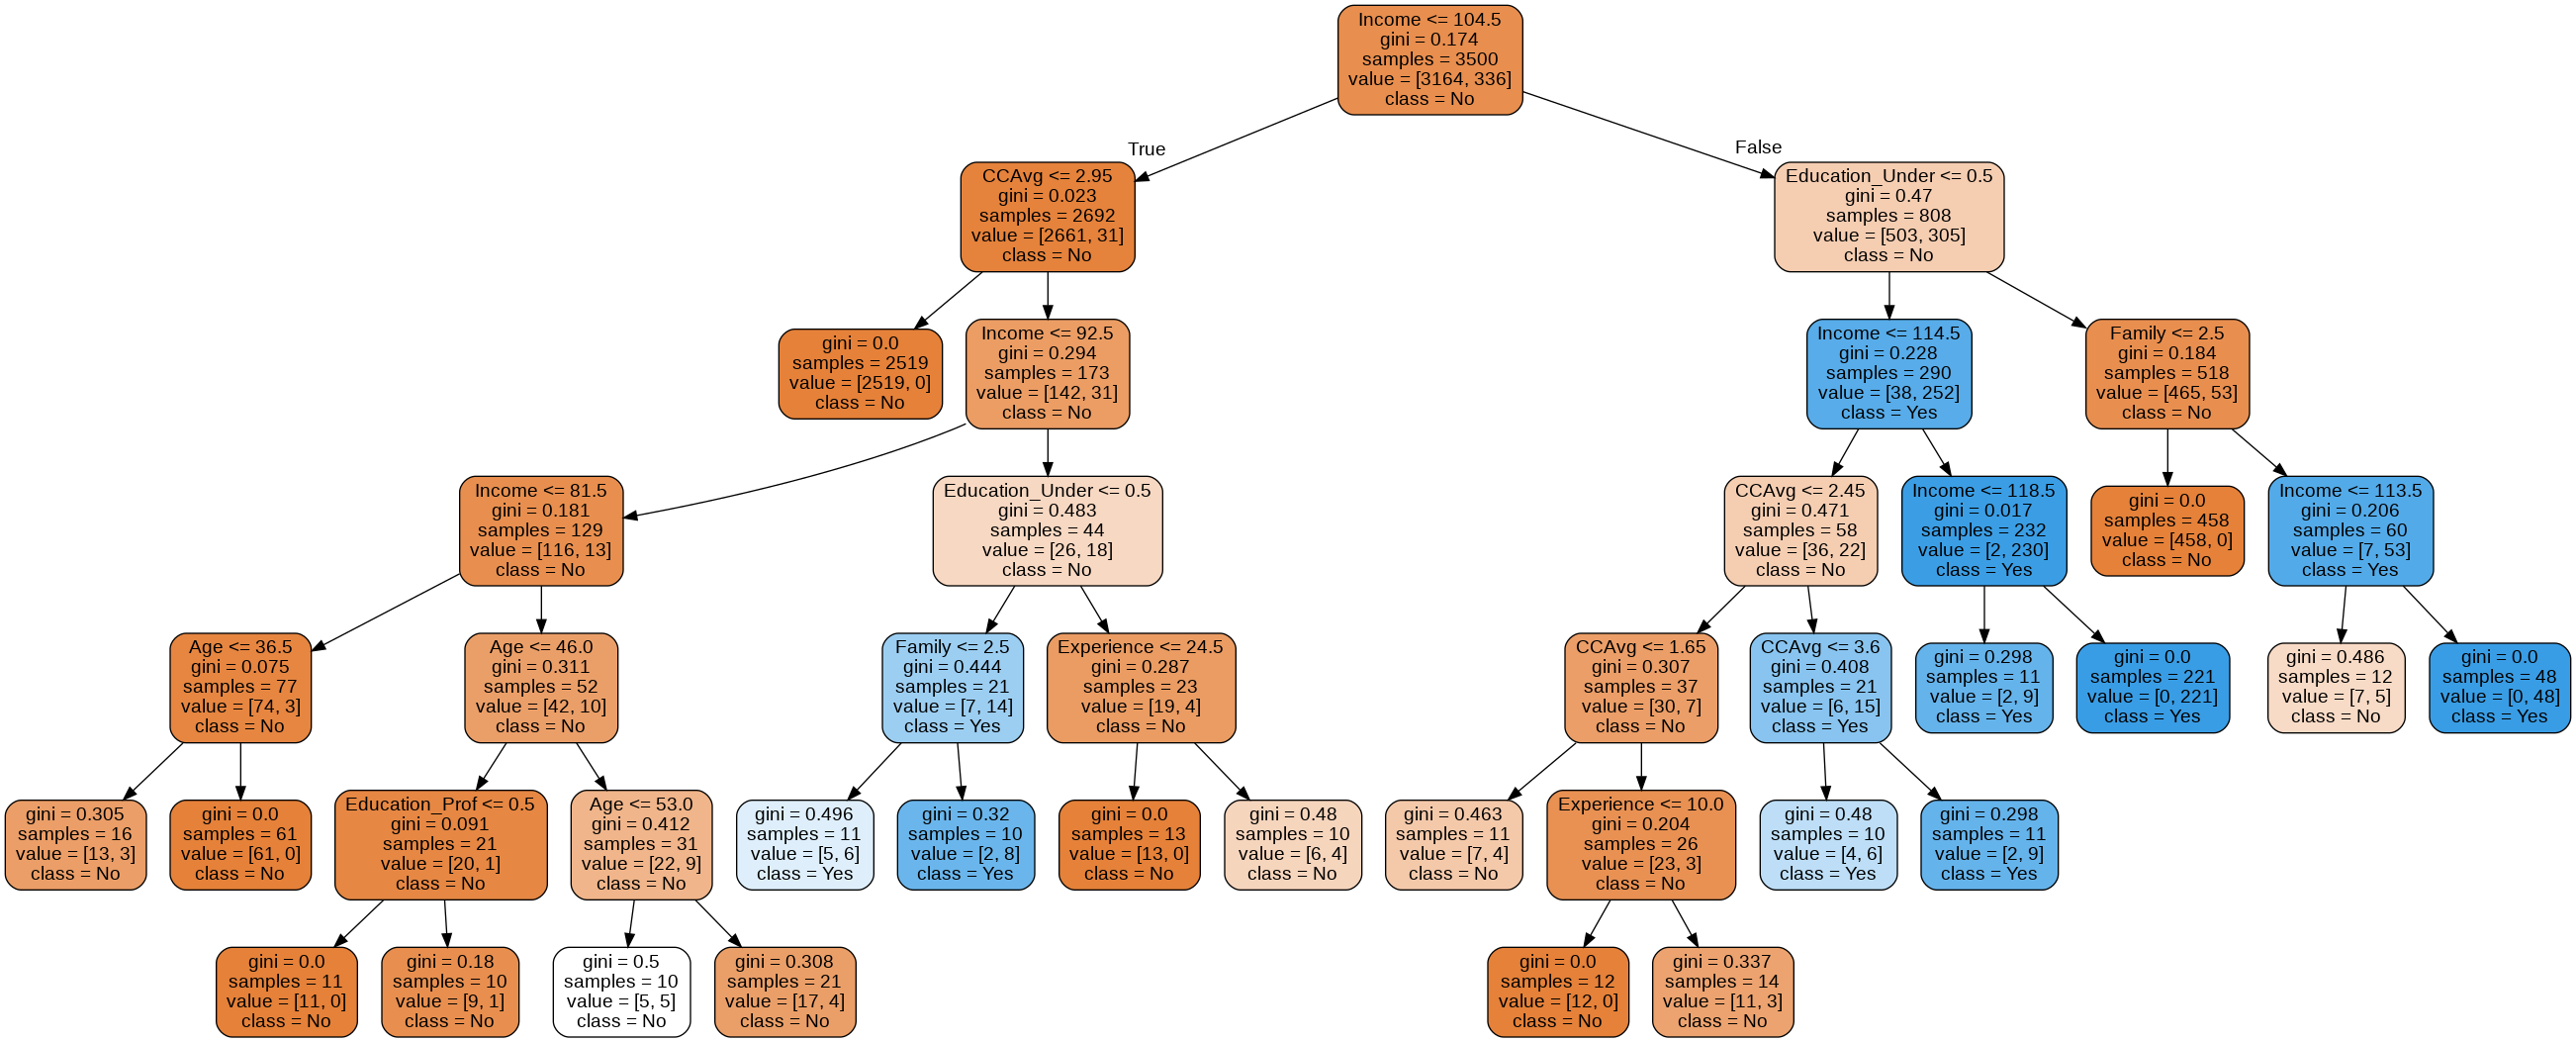

In [ ]:
dt_graph = pydotplus.graph_from_dot_data(dot_data)
Image(dt_graph.create_png())